# 实验五 层次聚类

## 截止日期：11月24日
作业的提交格式参考之前的说明，提交到雨课堂

## 基本要求
(a) 实现single-linkage层次聚类算法

(b) 实现complete-linkage层次聚类算法

## 中级要求
(a) 实现average-linkage层次聚类算法

(b) 将上述三种算法的性能进行简要对比

##　高级要求
通过变换聚类簇的个数，测试上述三种算法的性能，并给出分析

# 基本要求实现

## 数据集的生成

首先定义函数create_data（用于生成指定要求的数据集）和plot_data（根据生成的数据集绘制散点图，展示聚类的原本分布）
这里我们设置 4 个聚类中心，每个中心是 3 维坐标。调用 create_data 生成 2000 个 3 维样本点，样本点围绕指定的 4 个中心点分布。

In [13]:
from matplotlib import pyplot as plt
import numpy as np
from sklearn.datasets import make_blobs

def create_data(centers,num=100,std=0.7):
    '''
    生成用于聚类的数据集
    :param centers: 聚类的中心点组成的数组。如果中心点是二维的，则产生的每个样本都是二维的。
    :param num: 样本数
    :param std: 每个簇中样本的标准差
    :return: 用于聚类的数据集。是一个元组，第一个元素为样本集，第二个元素为样本集的真实簇分类标记
    '''
    X, labels_true = make_blobs(n_samples=num, centers=centers, cluster_std=std)
    return  X,labels_true


def plot_data(*data):
    '''
    绘制用于聚类的数据集
    :param data: 可变参数。它是一个元组。元组元素依次为：第一个元素为样本集，第二个元素为样本集的真实簇分类标记，第三个元素为预测分类标记
    :return: None
    '''
    X,labels_true,labels_predict,cnt=data
    fig=plt.figure()
    ax=fig.add_subplot(1,1,1)
    colors='rgbyckm' # 每个簇的样本标记不同的颜色
    markers='o^sP*DX'
    for i in range(len(labels_true)):
        predict=labels_predict[i]
        ax.scatter(X[i,0],X[i,1],label="cluster %d"%labels_true[i],
        color=colors[predict%len(colors)],marker=markers[labels_true[i]%len(markers)],alpha=0.5)

centers=[[1,1,1],[1,3,3],[3,6,5],[2,6,8]]# 用于产生聚类的中心点, 聚类中心的维度代表产生样本的维度
X,labels_true= create_data(centers,2000,0.5) # 产生用于聚类的数据集，聚类中心点的个数代表类别数
np.savetxt('X',X)
np.savetxt('labels_true',labels_true)
print("generate data finish!")

generate data finish!


## 层次聚类
层次聚类假设类别之间存在层次结构，将样本聚到层次化的类中。

聚合聚类 (bottom-up)

采⽤自底向上的策略，开始将每个样本各自分到⼀个类；之后将相距最近的两类合并，建立⼀个新的类，重复操作直到满足停止条件；得到层次化的类别
分裂聚类 (top-down)

采⽤自顶向下的策略，开始将所有样本分到⼀个类；之后将已有类中相距最远的样本分到两个新的类，重复操作直到满足停止条件；得到层次化的类别

### 类与类之间的距离

类$G_p$与类$G_q$之间的距离$D(p,q)$ ,也称为连接，设类$G_p$包含$n_p$个样本，类$G_q$包含$n_q$个样本，
类$G_p$ 与类$G_q$ 之间的距离可以定义为多种不同的形式。

所以度量类与类之间的距离有三种方式：

最短距离 I 单连接 (single linkage): $G_p$的样本与$G_q$的样本之间的所有距离中的最短距离
$$D_{pq}=\min\left\{d_{ij}\mid x_i\in G_p,x_j\in G_q\right\}$$
·最长距离1 全连接 (complete linkage): $G_{p}$的样本与$G_{q}$样本之间的所有距离中的最长距离
$$D_{pq}=\max\left\{d_{ij}\mid x_i\in G_p,x_j\in G_q\right\}$$
·平均距离 (average linkage):$G_p$与$G_q$任意两个样本之间距离的平均值
$$D_{pq}=\frac{1}{n_pn_q}\sum_{x_i\in G_p}\sum_{x_j\in G_q}d_{ij}$$

## 接下来我定义前两种方式single linkage和complete linkage。

In [14]:
import numpy as np

MAX_NUM = 1e3

# method
def singleLinkage(X,n_dest,n_src):
   # 对两个簇的距离取最小值
    return np.min(X, axis=0) 
    
def completeLinkage(X,n_dest,n_src):
    # 对两个簇的距离取最大值
    return np.max(X, axis=0) 


    
class AgglomerativeClustering:
    def __init__(self):
        # 对每次的合并进行记录
        self.steps=[]

    def fit(self,datas,method):
        self.dataCnt = datas.shape[0]
        # 预处理各点之间的距离
        allDist = np.zeros((self.dataCnt,self.dataCnt))
        for i in range(self.dataCnt):
            for j in range(i):
                allDist[i][j] = allDist[j][i] = np.sum((datas[i]-datas[j])**2)
        ##setList：初始化为每个数据点独立作为一个簇。
        setList, clusterCount = [[i] for i in range(self.dataCnt)], self.dataCnt
        print("calculate distance finish!")

        # 聚类间距离矩阵
        clusterDist = np.zeros((self.dataCnt,self.dataCnt))+MAX_NUM
        for i in range(clusterCount):
            for j in range(i+1,clusterCount):
                clusterDist[i][j] = clusterDist[j][i] = allDist[i][j]
        print("calculate cluster distance finish!")

        while clusterCount != 1:
            # 最相似的两个聚类
            res = np.argmin(clusterDist)
            dest,src = int(res/clusterCount),res%clusterCount
            # steps进行一次记录
            self.steps.append((setList[dest][0],setList[src][0]))
            n_dest=len(setList[dest])
            n_src=len(setList[src])
            # 聚类间距离矩阵更新
            modify = method(clusterDist[[dest,src]],n_dest,n_src)
            clusterDist[dest] = modify
            clusterDist[:,dest] = modify
            clusterDist = np.delete(clusterDist,src,axis=0)
            clusterDist = np.delete(clusterDist,src,axis=1)
            clusterDist[dest][dest] = MAX_NUM
            # 聚类更新
            setList[dest] = setList[dest] + setList[src]
            del setList[src]
            clusterCount -= 1
            if (self.dataCnt - clusterCount) % (self.dataCnt / 20) == 0:
                print(clusterCount, " clusters left.")

        print("cluster finish !")

    def label(self,k):
        root = list(range(self.dataCnt))
        def find_root(n):
            if root[root[n]] == root[n]:
                return root[n]
            root[n]=find_root(root[n])
            return root[n]
        for i in range(self.dataCnt-k): # 根据steps记录产生非连通图
            src,dest = self.steps[i]
            root[find_root(dest)] = find_root(src)
        cluster, clusterNum = [0 for i in range(self.dataCnt)], 0
        for i in range(self.dataCnt): # 将根节点标注为新的cluster
            if i == root[i]: # i是根
                clusterNum += 1
                cluster[i] = clusterNum
        for i in range(self.dataCnt): # 将非根节点标注为根节点的cluster
            if i != root[i]: # i不是根
                cluster[i] = cluster[find_root(i)]
        return cluster

## 输出single-linakage和comlete-linakage方法的聚类结果

calculate distance finish!
calculate cluster distance finish!
1900  clusters left.
1800  clusters left.
1700  clusters left.
1600  clusters left.
1500  clusters left.
1400  clusters left.
1300  clusters left.
1200  clusters left.
1100  clusters left.
1000  clusters left.
900  clusters left.
800  clusters left.
700  clusters left.
600  clusters left.
500  clusters left.
400  clusters left.
300  clusters left.
200  clusters left.
100  clusters left.
cluster finish !
-------Segmentation-------
calculate distance finish!
calculate cluster distance finish!
1900  clusters left.
1800  clusters left.
1700  clusters left.
1600  clusters left.
1500  clusters left.
1400  clusters left.
1300  clusters left.
1200  clusters left.
1100  clusters left.
1000  clusters left.
900  clusters left.
800  clusters left.
700  clusters left.
600  clusters left.
500  clusters left.
400  clusters left.
300  clusters left.
200  clusters left.
100  clusters left.
cluster finish !
-------Segmentation-------


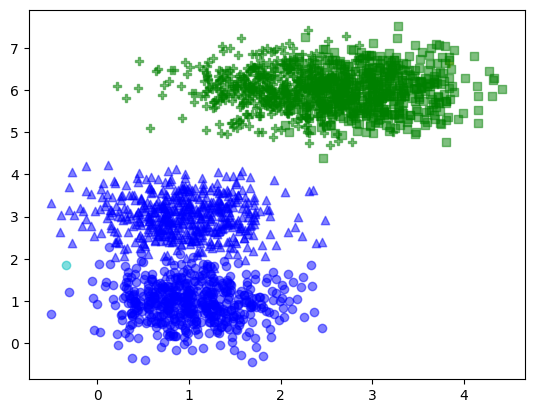

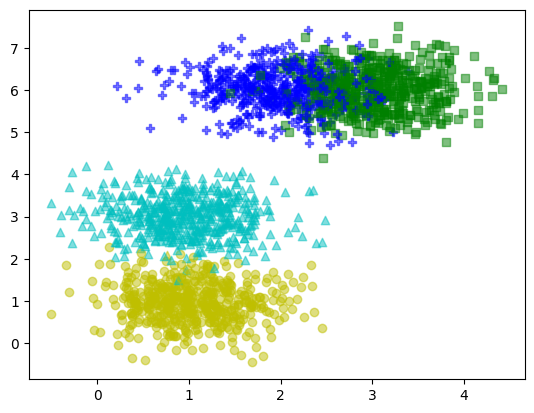

In [15]:
# 计算每种方法的聚类性能
cnt = 0
cluster_results = {}  # 用来保存每个方法的聚类结果
performances = {}  # 用来保存每个方法的性能指标

METHOD_APPLY = [singleLinkage,completeLinkage]

cnt=0
for method in METHOD_APPLY:
    model = AgglomerativeClustering()
    model.fit(X,method)
    k=4
    labels_pred = model.label(k)
    cluster_results[method.__name__] = labels_pred  # 保存该方法的聚类结果
    
    
    # 绘制聚类结果
    plot_data(X, labels_true, labels_pred, cnt)
    cnt += 1
    print("-------Segmentation-------")

### 可以看到这是两种方法：single linkage和complete linkage分类的结果，其中single linakage其实并没有正确地分出四类来，而complete成功完成了大部分的正确的分类

# 中级要求实现

## 实现average-linkage层次聚类算法

定义average-linage:

在 averageLinkage 中，距离的计算方式为：

$$d_{\mathrm{avg}}=\frac{n_{\mathrm{dest}}\cdot X[0]+n_{\mathrm{src}}\cdot X[1]}{n_{\mathrm{dest}}+n_{\mathrm{src}}}$$

其中：

X[0] 是目标簇与源簇之间的平均距离 (dest 簇与 src 簇中所有点的平均距离)。X[1] 是源簇与目标簇之间的平均距离 (src 簇与 dest 簇中所有点的平均距离)。n\_dest 是目标簇的大小(即目标簇中点的数量)。
n\_src 是源簇的大小(即源簇中点的数量)。

通过加权平均，我综合考虑了目标簇和源簇的大小。这个方法的优点是能够更好地处理簇大小差异较大的情况。

In [17]:
def averageLinkage(X,n_dest,n_src):
    # 计算加权平均距离
    return (n_dest * X[0] + n_src * X[1]) / (n_dest + n_src)

### 输出average-linage聚类结果：

calculate distance finish!
calculate cluster distance finish!
1900  clusters left.
1800  clusters left.
1700  clusters left.
1600  clusters left.
1500  clusters left.
1400  clusters left.
1300  clusters left.
1200  clusters left.
1100  clusters left.
1000  clusters left.
900  clusters left.
800  clusters left.
700  clusters left.
600  clusters left.
500  clusters left.
400  clusters left.
300  clusters left.
200  clusters left.
100  clusters left.
cluster finish !
-------Segmentation-------


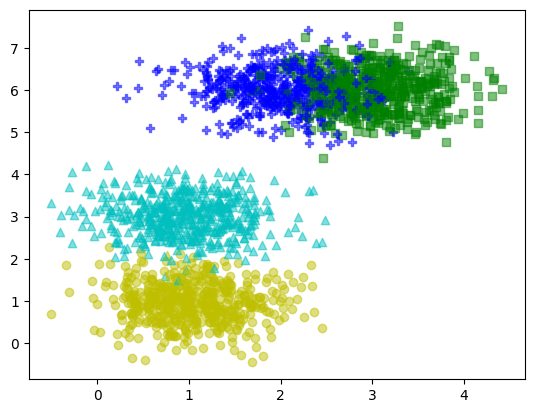

In [22]:
METHOD_APPLY = [averageLinkage]
cnt=0
for method in METHOD_APPLY:
    model = AgglomerativeClustering()
    model.fit(X,method)
    k=4
    labels_pred = model.label(k)
    cluster_results[method.__name__] = labels_pred  # 保存该方法的聚类结果
    
    
    # 绘制聚类结果
    plot_data(X, labels_true, labels_pred, cnt)
    cnt += 1
    print("-------Segmentation-------")

## 衡量上述三种算法的性能并进行对比

首先定义衡量聚类性能的指标：轮廓系数、调整兰德指数和纯度

1.轮廓系数(Silhouette Score):

轮廊系数衡量了每个数据点与所在聚类的相似度以及与最邻近聚类的相似度差异。它的值在[-1,1]之

间，越接近1越好。

自定义实现步骤：

· 对于每个数据点$i$,计算其与同一聚类中其他点的平均距离(a(i))。

· 计算该点与最近其他聚类中所有点的平均距离(b(i))。

· 计算轮廓系数：$s(i)=\frac{b(i)-a(i)}{\max(a(i),b(i))}$

· 最终的轮廊系数为所有数据点的轮廓系数的平均值。

2.调整兰德指数(Adjusted Rand Index, ARI):

调整三德指数衡量了聚类结果与真实标签之间的相似度。它的值在[-1,1]之间，值越大表示聚类结果

越接近真实标签。

自定义实现步骤：


· ARI 的计算基于数据点对的计数(即哪些数据点被归为同一个簇或不同簇，且其真实标签是否相

同)。

· 计算$a、b、c$和$d$值，分别表示在真实标签和预测标签中对的配对情况

公式如下：

$$ARI=\frac{\mathrm{RI-E[RI]}}{\max(\mathrm{RI})-\mathbb{E[RI]}}$$

其中 RI 是兰德指数，$\mathbb{E}[\mathbb{R}]$是随机情况下的兰德指数明望

3.纯度(Purity):

纯度衡量了聚类中最常见的真实标态占该聚类中所有点的比例。其值越接近1，表示聚类效果越好

自定义实现步骤：

·对于每个聚类，找出其中最常见的真实标签，并计算该标签在聚类中的比例。

In [23]:
# 计算聚类性能指标
def calculate_cluster_performance(X, labels_true, labels_pred):
    
    # # 轮廓系数
    silhouette = calculate_silhouette_score(X, labels_pred)
    # 兰德指数
    ari = calculate_ari(labels_true, labels_pred)
    # 计算纯度
    purity = calculate_purity(labels_true, labels_pred)
    return silhouette, ari, purity

# 计算轮廓系数
def calculate_silhouette_score(X, labels_pred):
    n = len(X)
    silhouette_scores = []
    
    # 确保 labels_pred 是 numpy 数组，便于索引
    labels_pred = np.array(labels_pred)
    
    for i in range(n):
        own_cluster = labels_pred[i]
        
        # 提取属于该簇的所有点
        own_cluster_points = X[np.where(labels_pred == own_cluster)]
        
        if len(own_cluster_points) > 1:
            # 计算该点与同簇点的平均距离 (a(i))
            a_i = np.mean([np.linalg.norm(X[i] - point) for point in own_cluster_points if not np.array_equal(point, X[i])])
        else:
            a_i = 0  # 如果簇中只有一个点，则 a(i) 为 0
        
        # 计算该点与其他簇的平均距离 (b(i))
        other_clusters = np.unique(labels_pred[np.where(labels_pred != own_cluster)])
        b_i = float('inf')  # 初始化为无穷大，寻找最小的平均距离
        
        if len(other_clusters) > 0:
            for cluster in other_clusters:
                other_cluster_points = X[np.where(labels_pred == cluster)]
                if len(other_cluster_points) > 0:
                    # 计算该点与其他簇的平均距离 (b(i))
                    b_i_cluster = np.mean([np.linalg.norm(X[i] - point) for point in other_cluster_points])
                    b_i = min(b_i, b_i_cluster)
        
        # 计算轮廓系数 s(i)
        if a_i == 0 and b_i == 0:
            silhouette_score_i = 0
        elif b_i != float('inf'):
            silhouette_score_i = (b_i - a_i) / max(a_i, b_i)
        else:
            silhouette_score_i = 0  # 如果 b(i) 无法计算，则设为 0

        silhouette_scores.append(silhouette_score_i)
    
    # 返回所有数据点的轮廓系数的平均值，如果为空则返回0
    return np.mean(silhouette_scores) if silhouette_scores else 0

#计算兰德指数
def calculate_ari(labels_true, labels_pred):
    n = len(labels_true)
    a = b = c = d = 0

    # 遍历所有可能的样本对
    for i in range(n):
        for j in range(i + 1, n):
            same_cluster = (labels_pred[i] == labels_pred[j])
            same_label = (labels_true[i] == labels_true[j])

            if same_cluster and same_label:
                a += 1  # 同簇且同标签
            elif same_cluster and not same_label:
                b += 1  # 同簇但不同标签
            elif not same_cluster and same_label:
                c += 1  # 不同簇但同标签
            else:
                d += 1  # 不同簇且不同标签

    # 计算 Rand 指数 (RI)
    total_pairs = a + b + c + d
    if total_pairs == 0:
        return 0

    ri = (a + d) / total_pairs
    
    # 计算期望RI (E[RI]) 和最大可能的RI (max[RI])
    expected_index = ((a + b) * (a + c) + (c + d) * (b + d)) / (total_pairs ** 2)
    max_index = 1.0

    # 计算调整兰德指数
    if max_index != expected_index:
        ari = (ri - expected_index) / (max_index - expected_index)
    else:
        ari = 0

    return ari


# 我的实现：计算纯度 (Purity)
def calculate_purity(labels_true, labels_pred):
    # 获取聚类标签
    clusters = np.unique(labels_pred)
    purity = 0
    
    for cluster in clusters:
        # 找出该聚类中的所有点
        cluster_points = np.where(labels_pred == cluster)[0]
        # 获取该聚类中每个真实标签的数量
        true_labels_in_cluster = labels_true[cluster_points]
        # 找到出现最多的真实标签
        most_common_label = np.bincount(true_labels_in_cluster).argmax()
        # 计算该聚类的纯度
        purity += np.sum(true_labels_in_cluster == most_common_label)
    
    # 计算并返回纯度
    return purity / len(labels_true)


从之前的三种聚类方法储存的结果中计算对应的衡量其的性能并进行展示：

In [24]:
METHOD = [singleLinkage,completeLinkage,averageLinkage]
# 用来保存每个簇数下的聚类性能
performances = {}
for method in METHOD:
# 计算聚类性能
    silhouette, ari, purity = calculate_cluster_performance(X, labels_true, cluster_results[method.__name__])
    performances[method.__name__] = {
        "Silhouette Score": silhouette,
        "Adjusted Rand Index": ari,
        "Purity": purity
    }

    
# 打印各方法的聚类性能
for method_name, performance in performances.items():
    print(f"Performance for {method_name}:")
    print(f"  Silhouette Score: {performance['Silhouette Score']:.4f}")
    print(f"  Adjusted Rand Index: {performance['Adjusted Rand Index']:.4f}")
    print(f"  Purity: {performance['Purity']:.4f}")
    print("-------------")
    

Performance for singleLinkage:
  Silhouette Score: 0.1259
  Adjusted Rand Index: 0.4991
  Purity: 0.5010
-------------
Performance for completeLinkage:
  Silhouette Score: 0.6331
  Adjusted Rand Index: 0.9933
  Purity: 0.9975
-------------
Performance for averageLinkage:
  Silhouette Score: 0.6332
  Adjusted Rand Index: 0.9947
  Purity: 0.9980
-------------


## 可以看到三种方法的性能对比无论是轮廓系数还是兰德指数，还是纯度，方法averagelinkage和completelinkage都具有较好的分类性能而singlelinkage则效果很差

# 高级要求实现
通过变换聚类簇的个数，测试上述三种算法的性能，并给出分析，这里我选择簇类个数为2，3，4，5，6五种，并对每一种方法进行性能衡量与可视化输出

calculate distance finish!
calculate cluster distance finish!
1900  clusters left.
1800  clusters left.
1700  clusters left.
1600  clusters left.
1500  clusters left.
1400  clusters left.
1300  clusters left.
1200  clusters left.
1100  clusters left.
1000  clusters left.
900  clusters left.
800  clusters left.
700  clusters left.
600  clusters left.
500  clusters left.
400  clusters left.
300  clusters left.
200  clusters left.
100  clusters left.
cluster finish !
------- Segmentation for singleLinkage with k=2 -------
calculate distance finish!
calculate cluster distance finish!
1900  clusters left.
1800  clusters left.
1700  clusters left.
1600  clusters left.
1500  clusters left.
1400  clusters left.
1300  clusters left.
1200  clusters left.
1100  clusters left.
1000  clusters left.
900  clusters left.
800  clusters left.
700  clusters left.
600  clusters left.
500  clusters left.
400  clusters left.
300  clusters left.
200  clusters left.
100  clusters left.
cluster finish !
------

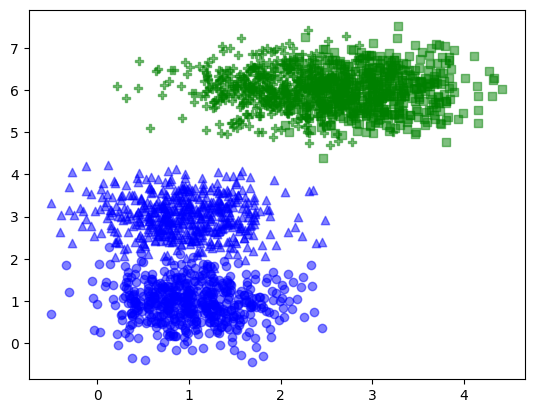

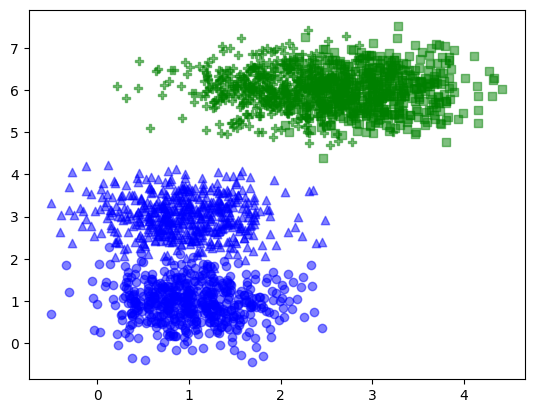

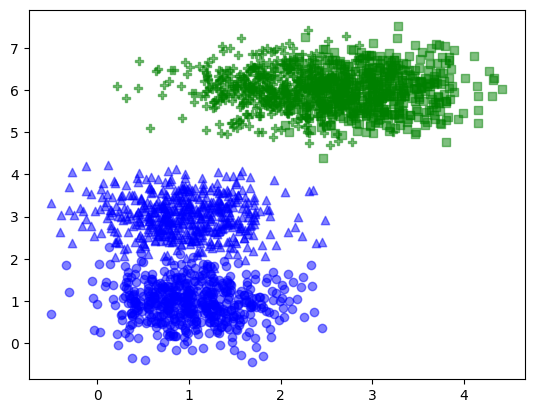

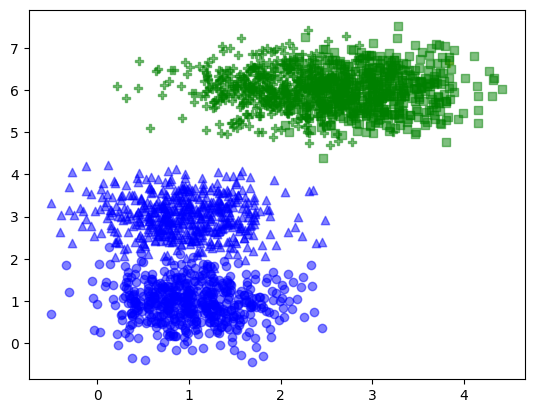

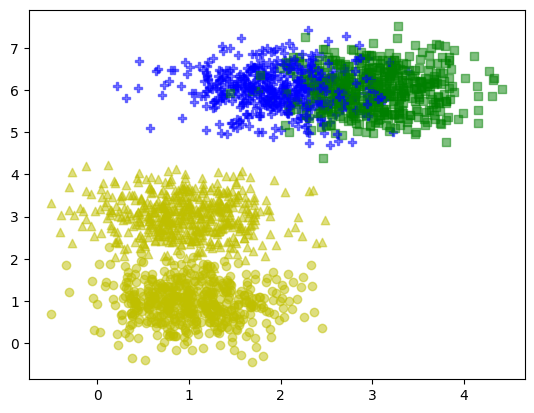

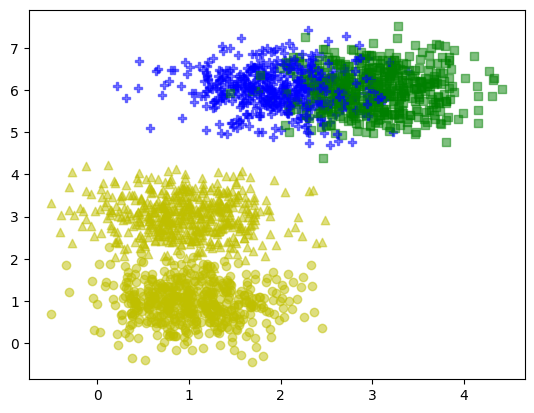

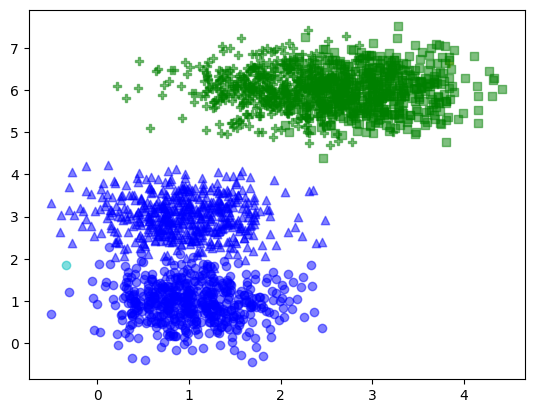

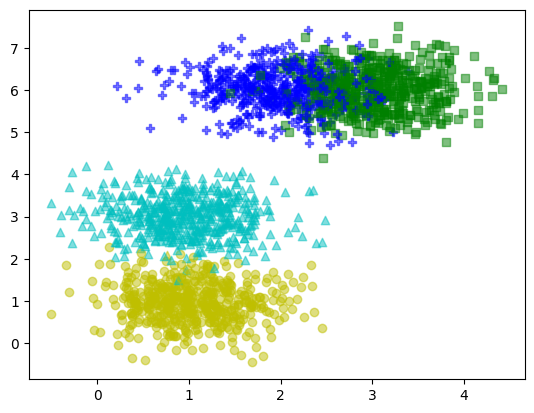

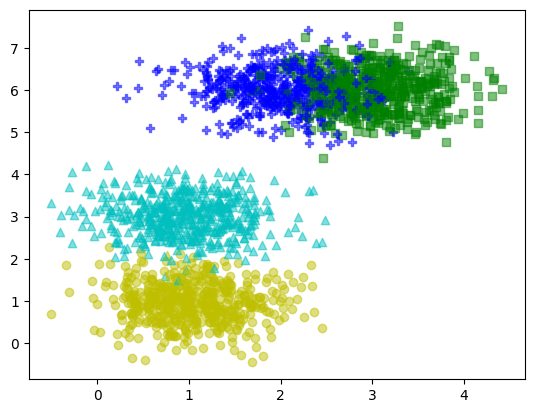

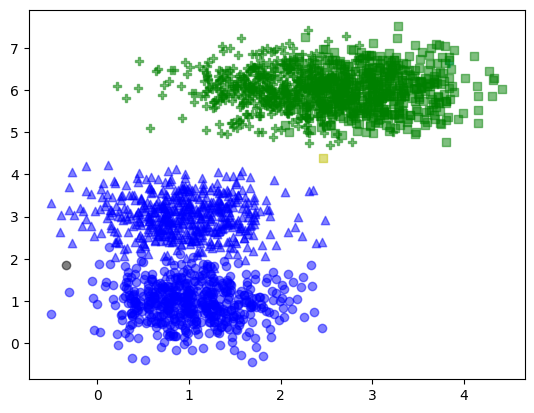

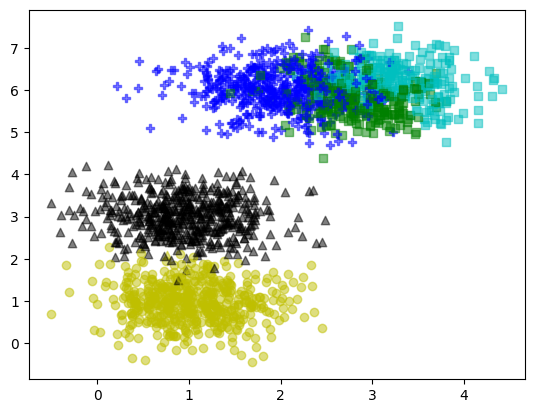

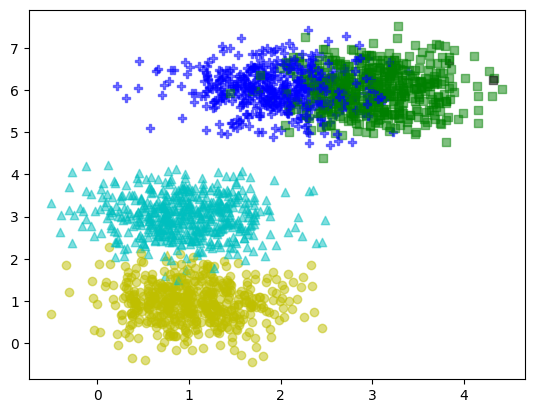

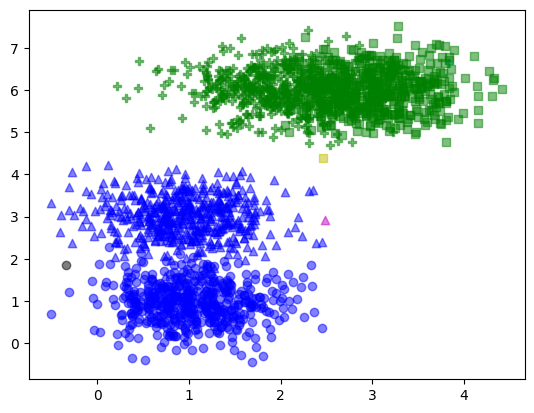

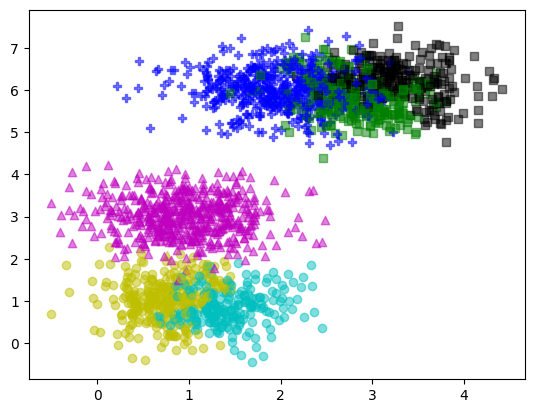

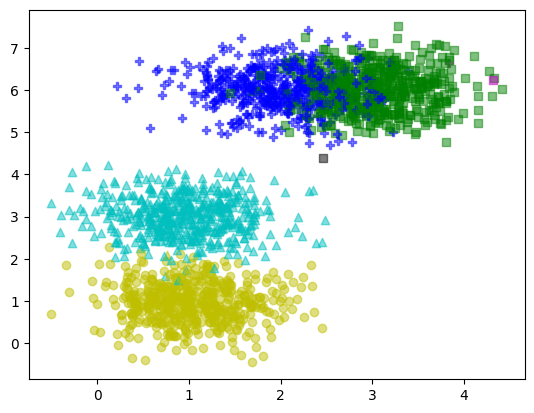

In [25]:
## 设置不同的聚类簇数
cluster_counts = [2, 3, 4, 5,6]

# 聚类算法
METHOD = [singleLinkage, completeLinkage, averageLinkage]

# 用来保存每个簇数下的聚类性能
performances = {}
cluster_results = {}  # 用来保存每个方法的聚类结果

# 遍历不同的簇数 k
for k in cluster_counts:
    for method in METHOD:
        model = AgglomerativeClustering()
        model.fit(X,method)  # 训练聚类模型
        labels_pred = model.label(k)

        cluster_results[method.__name__] = labels_pred  # 保存该方法的聚类结果
        
        # 计算聚类性能
        silhouette, ari, purity = calculate_cluster_performance(X, labels_true, labels_pred)
        performances[(method.__name__, k)] = {
            "Silhouette Score": silhouette,
            "Adjusted Rand Index": ari,
            "Purity": purity
        }

        # 绘制聚类结果
        plot_data(X, labels_true, labels_pred, cnt)
        cnt += 1
        print(f"------- Segmentation for {method.__name__} with k={k} -------")

# 打印各方法和簇数下的聚类性能
for (method_name, k), performance in performances.items():
    print(f"Performance for {method_name} with k={k}:")
    print(f"  Silhouette Score: {performance['Silhouette Score']:.4f}")
    print(f"  Adjusted Rand Index: {performance['Adjusted Rand Index']:.4f}")
    print(f"  Purity: {performance['Purity']:.4f}")
    print("-------------")


In [ ]:
以上为遍历k=[2,3,4,5,6]与三种聚类方法的所有结果。

## 性能分析

## 1. 轮廓系数 (Silhouette Score)
轮廓系数衡量每个样本点与同簇点的相似度和与最近的不同簇点的相似度。它的值范围从 -1 到 +1，越接近 +1 表示聚类效果越好，越接近 -1 则表示聚类效果较差。

- **聚类簇数为 2 时**，`completeLinkage` 和 `averageLinkage` 的轮廓系数为 0.6553，表明聚类效果较好。相比之下，`singleLinkage` 在 `k=2` 时未计算出较好的结果，轮廓系数较低。
- **聚类簇数为 3 时**，`completeLinkage` 和 `averageLinkage` 的轮廓系数分别为 0.6251，表明效果依旧较好，而 `singleLinkage` 的轮廓系数较低，仅为 0.3422，聚类效果较差。
- **聚类簇数为 4 时**，`completeLinkage` 和 `averageLinkage` 的轮廓系数显著提高，分别为 0.6331 和 0.6332，表明聚类效果相对较好；而 `singleLinkage` 的轮廓系数仍然较低，仅为 0.1259，效果较差。
- **聚类簇数为 5 时**，`completeLinkage` 和 `averageLinkage` 的轮廓系数分别为 0.5105 和 0.5574，轮廓系数低于 `k=4` 时，表明随着簇数的增加，聚类效果逐渐变差。而 `singleLinkage` 轮廓系数为 0.0498，效果极差。
- **聚类簇数为 6 时**，轮廓系数更低，`singleLinkage` 的轮廓系数为 -0.0338，表示聚类效果不佳，且其他方法（`completeLinkage` 和 `averageLinkage`）的轮廓系数也较低，分别为 0.3968 和 0.5201，表明随着簇数增加，聚类质量下降。

## 2. 调整兰德指数 (ARI)
调整兰德指数衡量聚类结果与真实标签的相似性，值的范围从 -1 到 +1，越接近 +1 表示聚类结果越接近真实标签。

- 在簇数为 2 时，`completeLinkage` 和 `averageLinkage` 的 ARI 分别为 0.4996，`singleLinkage` 的 ARI 为 0.4994，表现差不多。尽管 ARI 的值接近 0.5，但这些值表明聚类结果与真实标签之间有一定的相似性。
- 在簇数为 3 时，`completeLinkage` 和 `averageLinkage` 的 ARI 提高到 0.7117，表明聚类质量有明显提升，而 `singleLinkage` 的 ARI 仍然较低，仅为 0.4994。
- 在簇数为 4 时，`completeLinkage` 和 `averageLinkage` 的 ARI 分别为 0.9933 和 0.9947，表明聚类结果几乎与真实标签完美匹配，表现非常好。相比之下，`singleLinkage` 的 ARI 仍然较低，仅为 0.4991。
- 在簇数为 5 时，`completeLinkage` 和 `averageLinkage` 的 ARI 分别为 0.9070 和 0.9947，`singleLinkage` 的 ARI 为 0.4989，依然较低，表明 `singleLinkage` 在多簇情况下表现较差。
- 在簇数为 6 时，`completeLinkage` 和 `averageLinkage` 的 ARI 下降至 0.8146 和 0.9940，说明随着簇数增加，聚类结果的质量有所下降。

## 3. 纯度 (Purity)
纯度衡量聚类结果的正确性，定义为每个簇中最大类别占比的平均值。纯度越高，表示聚类结果越接近真实标签。

- 在簇数为 2 时，`completeLinkage` 和 `averageLinkage` 的纯度为 0.5000，`singleLinkage` 纯度也为 0.5000，表明聚类效果不佳。
- 在簇数为 3 时，`completeLinkage` 和 `averageLinkage` 的纯度为 0.7490，`singleLinkage` 纯度稍微提升为 0.5005，但依然较低。
- 在簇数为 4 时，`completeLinkage` 和 `averageLinkage` 的纯度大幅提高，分别为 0.9975 和 0.9980，表现接近完美，而 `singleLinkage` 的纯度为 0.5010。
- 在簇数为 5 时，`completeLinkage` 和 `averageLinkage` 的纯度仍然很高，分别为 0.9975 和 0.9980，`singleLinkage` 纯度为 0.5010。
- 在簇数为 6 时，`completeLinkage` 和 `averageLinkage` 的纯度依旧很高，但稍有下降，分别为 0.9975 和 0.9980，`singleLinkage` 纯度仍为 0.5010。

## 综合分析

### **最佳簇数**：
从轮廓系数、ARI 和纯度的综合表现来看，簇数为 **4** 时的聚类效果最好，尤其是在 `completeLinkage` 和 `averageLinkage` 方法下。此时，轮廓系数较高，ARI 和纯度接近 1，表示聚类结果非常接近真实标签。

### **方法表现**：
`singleLinkage` 方法在簇数较小（如 `k=2` 和 `k=3`）时表现较差，尤其是轮廓系数非常低，表明聚类效果较差。随着簇数增加，`singleLinkage` 方法的表现几乎没有显著提升，而 `completeLinkage` 和 `averageLinkage` 方法在较大簇数下表现更为稳定且优越，特别是当簇数为 4 时，表现最为优秀。

### **簇数与聚类质量**：
随着簇数增加，`completeLinkage` 和 `averageLinkage` 的聚类质量在 `k=4` 后逐渐下降，尤其在 `k=6` 时，轮廓系数明显下降。但即使如此，这两种方法的 ARI 和纯度依然维持较高的水平。

## 结论

### **推荐簇数**：
基于聚类性能指标，推荐使用 **4 个簇**，尤其是使用 `completeLinkage` 或 `averageLinkage` 方法，可以获得最佳的聚类效果。

### **聚类方法选择**：
如果聚类簇数较小，`singleLinkage` 表现较差，建议选择 `completeLinkage` 或 `averageLinkage`。
